### Bayesian Data Analysis, 3rd ed
##  Chapter 3, demo 6

Illustrate posterior inference for Bioassay data (BDA3 p. 74-).

#### Instructions for exercise (3.11 in BDA3)
- Check that the range and spacing of A and B are sensible for the 
  alternative prior
- Compute the log-posterior in a grid
- Scale the log-posterior by subtracting its maximum value before
  exponentiating (think why this is useful)
- Exponentiate
- Normalize the posterior
- Use 2D grid sampling 
- In addition to the plots, report p(beta>0|x,y)

In [3]:
# initial steps
import numpy as np
import scipy.stats

%matplotlib inline
from matplotlib import pyplot as plt 
plt.rc('font', size=12)

In [13]:
# Generate prior
priamean = 0.0
priastd = 2
pribmean = 10
pribstd = 10
corrab = 0.5
primean = np.array([priamean, pribmean])
pricov = np.array([[pow(priastd, 2), corrab*priastd*pribstd], [corrab*priastd*pribstd, pow(pribstd, 2)]])

multivar_norm_dist = scipy.stats.multivariate_normal(
    mean=primean, 
    cov=pricov
)

# Sample a grid of points for alpha and beta
AA = np.linspace(-8, 8, 100)
BB = np.linspace(-20, 40, 100)
# https://stackoverflow.com/questions/36013063/what-is-purpose-of-meshgrid-in-python/36014504#36014504
A, B = np.meshgrid(AA, BB)

### Compute prior for Multivariate Normal Distribution

In [14]:
# compute prior in the grid points
# https://stackoverflow.com/a/28930580/3067013
prior_flattened = np.array(
    [multivar_norm_dist.pdf(
        [x, y]) for [x,y] in zip(np.ravel(A), np.ravel(B)) 
    ]
)
prior = prior_flattened.reshape(A.shape)

### The bottom is the same as above but ugly.

In [15]:
prior2 = np.empty((len(BB),len(AA))) # allocate space
for i in range(len(AA)):
    for j in range(len(BB)):
        prior2[j,i] = multivar_norm_dist.pdf([AA[i], BB[j]])

prior == prior2

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

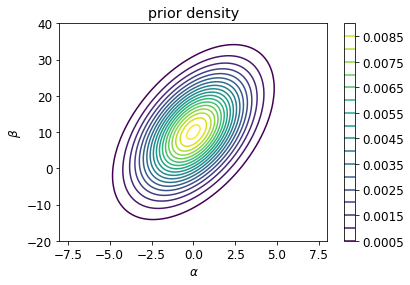

In [16]:
# plot the prior
plt.contour(A, B, prior, 20)
plt.colorbar()
plt.xlabel(r'$\alpha$') 
plt.ylabel(r'$\beta$')
plt.title('prior density')
plt.show()
# plt.savefig("prior.pdf", bbox_inches='tight')


Now let us create a similar grid of α and β values and compute the likelihood, prior, and posterior in the grid points. We will also sample 1000 points from the posterior, and plot the samples next to the posterior density contour.

In [17]:
# Seed a random state
rng = np.random.RandomState(0)

# data from the experiment
x = np.array([-0.86, -0.30, -0.05, 0.73]) 
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

A = np.linspace(-8, 7, 200)
B = np.linspace(-20, 40, 200) 
X,Y = np.meshgrid(A,B)

In [18]:
# compute the log-likelihood in the grid points
########## Question ##########
'''
The following throws divideByZero Error
A = np.linspace(-8, 7, 100)

A = np.linspace(-8, 8, 200)
'''
log_ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None]*x)) + 1)
# logfactor
log_likelihood = np.sum(np.log(log_ilogit_abx)*y  + (n-y)*np.log(1.0 - log_ilogit_abx), axis=2)

In [19]:
# Compute the logarithm of the prior in the grid points
prior_flattened = np.array(
    [np.log(multivar_norm_dist.pdf([x,y])) for [x,y] in
        zip(np.ravel(X), np.ravel(Y))
    ]
)
log_prior = prior_flattened.reshape(X.shape)

In [20]:
########## Question ##########
'''
Where was this formula mentioned?
'''
# Compute the posterior and normalize it
log_post = log_prior + log_likelihood
# log_post = log_post - np.max(log_post)  # Seems useless
log_post = np.exp(log_post)
# Normalize, since 0 <= p <= 1.
post = log_post / np.sum(log_post)

In [21]:
# sample 1000 points from the grid
nsamp = 1000
sample_indices = np.unravel_index(
    rng.choice(post.size, size=nsamp, p=post.ravel()/np.sum(post)),
    post.shape
)
# sample_indices

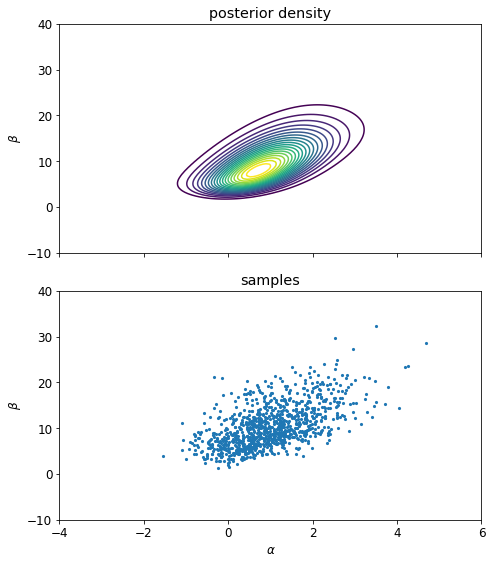

In [22]:
samp_A = A[sample_indices[1]]
samp_B = B[sample_indices[0]]

# add random jitter
samp_A += (rng.rand(nsamp) - 0.5) * [A[1] - A[0]]
samp_B += (rng.rand(nsamp) - 0.5) * [B[1] - B[0]]

# create figure for the posterior and samples
fig, axes = plt.subplots(2, 1, figsize=(7,8), sharex=True)

# Plot the posterior density
ax = axes[0]
ax.contour(A,B,post,20)
ax.set_xlim([-4,6])
ax.set_ylim([-10,40])
ax.set_ylabel(r'$\beta$') 
ax.grid('off')
ax.set_title('posterior density')


# plot the samples
ax = axes [1]
ax.scatter(samp_A , samp_B , 10, linewidth=0)
ax.set_xlim([-4,6])
ax.set_ylim([-10,40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')
fig.tight_layout()

#### Figure 2: A plot of the probability density function of the posterior for (α,β), together with 1000 samples from the posterior.

Now let us compute the LD50 parameter, i.e. the dose level at which the probability of death is 50%. In the logistic model this is given by

E(yi)=logit−1(α+βxi)= 1. (6) ni 2

This is true when xi = −α/β. Because the LD50 is meaningless when β ≤ 0 (then dose increase will not increase the death probability), we will generate a histogram of the LD50 values computed from the 1000 posterior samples, but discard those where β ≤ 0. The histogram is plotted in Figure 3.

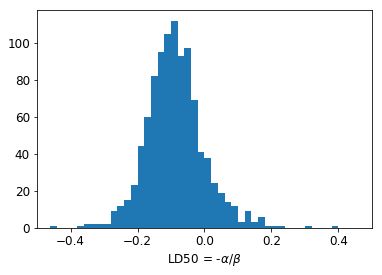

In [12]:
# Compute samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi]/samp_B[bpi]
'''
NOTE:
    In this case, 
    samp_ld50 = -samp_A[bpi]/samp_B[bpi]
    and,
    samp_ld50 = -samp_A/samp_B
    give the same result because,
        x > 0 for every x in sampe_B
    
    Therefore,
        samp_A[bpi] == samp_A
        samp_ld50 == -samp_A/samp_B
'''

# Plot the histogram of LD50
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$')

A = np.linspace(-8, 7, 200)
B = np.linspace(-20, 40, 200) 
#### Figure 3: A histogram of LD50 values, where β > 0.

In order to compare the densities of the prior, posterior, and likelihood, they are plotted next to each other in Figure 4. The plot shows that the posterior is a compromise between the prior and likelihood. In addition, the Figure 2 shows that the scatter plot is very similar to the posterior density, so we can conclude that both the posterior density and samples from it represent a compromise between the prior and likelihood.

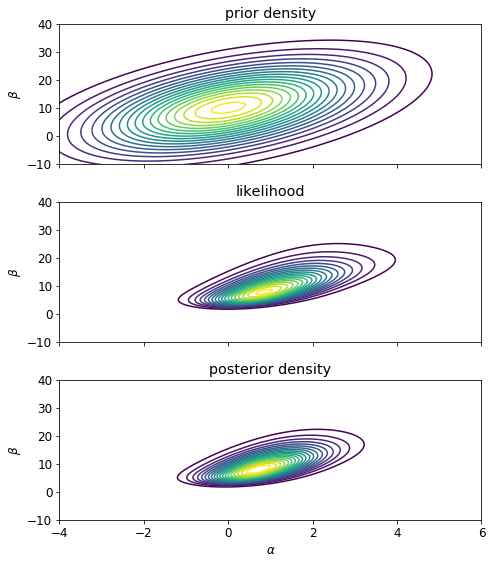

In [13]:
prior_A = np.linspace(-8, 8, 100)
prior_B = np.linspace(-20, 40, 100) 

fig, axes = plt.subplots(3, 1, figsize=(7,8), sharex=True)

# Plot the posterior density
ax = axes[0]
ax.contour(prior_A,prior_B,prior,20)
ax.set_xlim([-4,6])
ax.set_ylim([-10,40])
ax.set_ylabel(r'$\beta$') 
ax.grid('off')
ax.set_title('prior density')

ax = axes[1]
ax.contour(A,B,np.exp(log_likelihood),20)
ax.set_xlim([-4,6])
ax.set_ylim([-10,40])
ax.set_ylabel(r'$\beta$') 
ax.grid('off')
ax.set_title('likelihood')

ax = axes[2]
ax.contour(A,B,post,20)
ax.set_xlim([-4,6])
ax.set_ylim([-10,40])
ax.set_ylabel(r'$\beta$') 
ax.set_xlabel(r'$\alpha$')
ax.grid('off')
ax.set_title('posterior density')

fig.tight_layout()

#### Figure 4: Comparison of the densities of the prior, posterior, and the likelihood. The figure shows that the posterior is a compromise between the prior and likelihood.

In order to get more accurate results, let us draw more LD50 samples. We will draw 1000000 samples from the posterior of α and β and compute the fraction of samples where β > 0.

In [25]:
nsamp = 1000000

########## Question ##########
'''

In
    p=post.ravel()/np.sum(post)
np.sum(post) == 1.
So why divide by 1?
'''
########## Question ##########
'''
How does `numpy.unravel_index` work?
'''

'''
RandomState.choice(
    a: Int or 1-D array-like, 
        If an ndarray, a random sample is generated from its elements. 
        If an int, the random sample is generated as if a were 
        np.arange(a)
    
    size: Int or Tuple(Int),
        Output shape. If the given shape is, e.g., (m, n, k), 
        then m * n * k samples are drawn. Default is None, 
        in which case a single value is returned.
    
    p: 1-D array-like
        The probabilities associated with each entry in a. 
        If not given the sample assumes a uniform distribution over 
        all entries in a.
)
Returns:
    samples : single item or ndarray
        The generated random samples
'''
print(np.sum(post))
samp_indices = np.unravel_index(
    rng.choice(
        post.size, 
        size=nsamp,
        p=post.ravel()#/np.sum(post)
    ),
    post.shape 
)
print(np.sum(post))
samp_B = B[samp_indices[0]]

probability_b_over_zero = np.sum(samp_B > 0) / len(samp_B); 
probability_b_over_zero, post.size


1.0
1.0


(0.999996, 40000)

In [15]:
# timeit sum(n > 0 for n in samp_B) / len(samp_B)

In [16]:
# timeit np.sum(samp_B > 0) / len(samp_B)

# TEST CODE

In [17]:
post.ravel()/np.sum(post)

array([  4.34063272e-84,   6.34357852e-84,   9.22377147e-84, ...,
         1.64293867e-10,   1.38266919e-10,   1.16098911e-10])

In [18]:
post.ravel()post.ravel()

SyntaxError: invalid syntax (<ipython-input-18-dd8e816c31fc>, line 1)

In [ ]:
np.sum(post)

In [ ]:
a = np.array([[1,2,3],[4,3,1]])
i,j = np.unravel_index(a.argmax(), a.shape)
a.shape, i, j, a.argmax(),  a[i,j]

In [ ]:
c = rng.choice(
        post.size, 
        size=nsamp,
        p=post.ravel()/np.sum(post)
    )
c.shape, c

In [ ]:
k = samp_indices[0].shape
samp_B

In [ ]:
post.shape, post.size